# Nesreče na smučiščih

Vsako leto se v smučarski sezoni zgodi veliko nesreč, zato bova poskušala podatke o preteklih nesrečah analizirati in ugotoviti, kateri so ključni razlogi za nastanek nesreče, kakšne so najpostejše posledice, kakšni so bili pogoji smučanja in podobno.

## Podatki

[Povezava](https://podatki.gov.si/dataset/evidenca-nesrec-na-smuciscih1)

Podatke sva našla na spletni strani podatki.gov.si. Ker so nama datoteke CSV bolj domače od PCAXIS sva se odločila za te, čeprav je to precej zmanjšalo najino izbiro. Datoteka obsega podrobne informacije o nesrečah na slovenskih smučiščih za leta od 2013 do vključno 2017.

V podatkih je 23 atributov, to so oznaka zadeve, različne okoliščine nesreče (ura, veter, vreme...), podatki o udeležencih in drugo. Med podatki je veliko napak in manjkajočih vrednosti, zato bo te težave potrebno najprej odpraviti.

## Uporabljene knjižnice

In [1]:
import numpy as np
from csv import DictReader
from collections import OrderedDict
from matplotlib import pyplot as plt
import GPy # Predpogoj: namestitev GPy z ukazom => pip install gpy
import math
import random
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.cluster.hierarchy as sch

## Branje podatkov

In [2]:
# Datoteka mora biti v enaki mapi kot Main.py
# Vrne seznam slovarjev - vsaka vrstica je svoj slovar
def read_file(filename):
    try:
        with open(filename) as file:
            reader = DictReader(file, delimiter=";")
            return list(reader)
        
    except FileNotFoundError:
        print("File {0} not found. ".format(filename))

In [3]:
# read data
data = read_file("podatki.csv")

## Atributi

Atributi so v datoteki shranjeni vsak z svojo zaporedno številko, začnejo se še z veliko začetnico in vsebujejo tudi šumnike in druge znake, zato sva najprej te pretvorila v utrezno obliko. Odstranila sva zaporedno številko atributa, ime pretvorila v male črke ter zamenjala presledke s podčrtaji.

Skupno je 23 atributov, ki so navedeni spodaj.

In [4]:
# Odstrani šumnike in vodilne številke,
# pretvori v male črke
def format_key(attribute):
    slovar = {'č': 'c', 'š': 's', 'ž':'z', 'ć': 'c'}
    attribute = attribute.lower()
    splitted = attribute.split(" ")
    splitted.pop(0)
    output = ""
    for c in "_".join(splitted):
        if c in slovar:
            output += slovar[c]
        else: 
            output += c
    return output

In [5]:
def format_attributes(rows):
    for i, row in enumerate(rows):
        output = {}
        for key, value in row.items():
            output[format_key(key)] = value
        rows[i] = output

In [6]:
# formatiranje atributov
format_attributes(data)

# Izpis atributov
for key in data[0].keys():
    print(key)

stevilka_zadeve
datum_nesrece
ura_nesrece
nadzornik_prisoten
zdravnik_prisoten
resevalec_prisoten
udelezenec_a_–_leto_rojstva
udelezenec_a_–_drzava
udelezenec_a_–_zvrst_smucanja
udelezenec_a_–_ravnanje_pred_nesreco
udelezenec_b_–_leto_rojstva
udelezenec_b_–_drzava
udelezenec_b_–_zvrst_smucanja
udelezenec_b_–_ravnanje_pred_nesreco
skica_nesrece
fotografija_kraja_nesrece
posnetek_kraja_nesrece
vreme
vidljivost
temperatura
vrsta_snega
veter
telesna_poskodba


## Filtriranje podatkov

Določenim podatkom manjkajo vrednosti, ali pa so po nepotrebnem dodane. Nekaterim letom na primer manjka vodilna števka (983 namesto 1983), nekateri pa imajo vrednosti dodane, npr. '4 s snegom povsem pokrito smučišče' in 's snegom povsem pokrito smučišče' sta dve vrsti snega, čeprav gre za isto stvar. Te in podobne težave je potrebno odpraviti. 

In [7]:
def replace_value(value):
    value = value.strip(" ").lower()
    value = value.split(" ")
    value.pop(0)
    if value:
        return " ".join(value)
    return None

def replace_bool(value):
    value = value.strip()
    if not value or value == "Ne":
        return False
    return True

def replace_bool_unstrict(value):
    value = value.strip().lower()
    if not value:
        return None
    if value == "ne":
        return False
    return True

def replace_year(value):
    value = value.strip()
    if not value:
        return None
    if len(value) == 3:
        return "1" + str(value)
    if int(value) < 1900 or int(value) > 2016:
        return None
    return value

def replace_none(value):
    value = value.strip(" ").lower()
    if not value:
        return None
    return value

In [8]:
for i, row in enumerate(data):
    
    # nadzornik_prisoten, zdravnik_prisoten, resevalec_prisoten
    data[i]["nadzornik_prisoten"] = replace_bool_unstrict(row["nadzornik_prisoten"])
    data[i]["zdravnik_prisoten"] = replace_bool_unstrict(row["zdravnik_prisoten"])
    data[i]["resevalec_prisoten"] = replace_bool_unstrict(row["resevalec_prisoten"])
    
    # udeleženec A in B leto rojstva
    data[i]["udelezenec_a_–_leto_rojstva"] = replace_year(row["udelezenec_a_–_leto_rojstva"])
    data[i]["udelezenec_b_–_leto_rojstva"] = replace_year(row["udelezenec_b_–_leto_rojstva"])
    
    # udeleženec A in B ravnanje pred nesrečo
    data[i]["udelezenec_a_–_ravnanje_pred_nesreco"] = replace_value(row["udelezenec_a_–_ravnanje_pred_nesreco"])
    data[i]["udelezenec_b_–_ravnanje_pred_nesreco"] = replace_value(row["udelezenec_b_–_ravnanje_pred_nesreco"])
    
    # udeleženec A in B država
    data[i]["udelezenec_a_–_drzava"] = replace_none(row["udelezenec_a_–_drzava"])
    data[i]["udelezenec_b_–_drzava"] = replace_none(row["udelezenec_b_–_drzava"])
    
    # skica nesreče
    data[i]["skica_nesrece"] = replace_bool(row["skica_nesrece"])
    
    # fotografija nesreče
    data[i]["fotografija_kraja_nesrece"] = replace_bool(row["fotografija_kraja_nesrece"])
    
    # posnetek kraja nesreče
    data[i]["posnetek_kraja_nesrece"] = replace_bool(row["posnetek_kraja_nesrece"])
    
    # vreme
    data[i]["vreme"] = replace_value(row["vreme"])
    
    # vidljivost
    data[i]["vidljivost"] = replace_value(row["vidljivost"])
       
    # vrsta snega
    data[i]["vrsta_snega"] = replace_value(row["vrsta_snega"])
    
    # veter
    data[i]["veter"] = replace_value(row["veter"])

## Nesreče po posamezni uri

In [9]:
# Parameter rows so prebrani podatki
def accident_times(rows):
    hours = {}
    for row in rows:
        time = row["ura_nesrece"]
        hour = time.split(":")[0]
        if hour not in hours:
            hours[hour] = 0
        hours[hour] += 1

    # sort by hour
    count = OrderedDict(sorted(hours.items(), reverse=True))

    x = list(count.keys())
    y = list(count.values())
    plt.barh(x, y)
    plt.title("Nesreče po urah")
    plt.xlabel("Št. nesreč")
    plt.ylabel("Ura")
    plt.show()

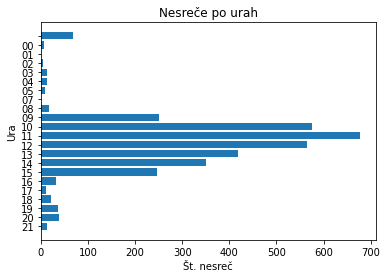

In [10]:
# plot accidents at given hour
accident_times(data)

Vidi se, da se največ nesreč zgodi med deveto uro zjutraj in štirih popoldne, ko je na smučišču največ ljudi. Med 22. uro in polnočjo pa ni bilo zabeležene nobene nesreče.

## Nesreče po mescih

Za vsako nesrečo je zabeležen datum, kdaj je do nje prišlo. Ta datum sva v naslednjem primeru pretvorila v številko mesca in preštela število nesreč za posamezni mesec. <br>Kot pričakovano je največ nesreč ravno v zimskih mesecih, ko se novembra začne smučarska sezona in traja vse do aprila. V poletnih mescih nesreč skoraj da ni, avgusta, septembra in oktobra pa ni bila zabeležena nobena nesreča.

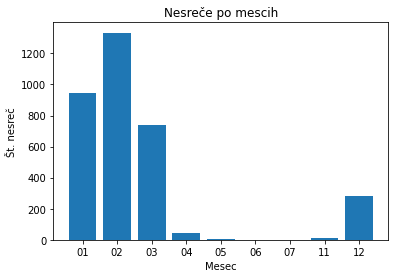

In [11]:
# Nesreče glede na mesec
def accident_date(rows):
    dates = {}
    
    for row in rows:
        date = row["datum_nesrece"]
        month = date.split(".")[1]
        if month not in dates:
            dates[month] = 0
        dates[month] += 1
    
    # sort by month
    count = OrderedDict(sorted(dates.items()))
    
    x = list(count.keys())
    y = list(count.values())
    plt.bar(x, y)
    plt.title("Nesreče po mescih")
    plt.ylabel("Št. nesreč")
    plt.xlabel("Mesec")
    plt.show()
    
accident_date(data)

## Prisotno osebje

In [12]:
def counter(rows, column):
    slovar = {}
    
    for row in rows:
        col = row[column]
        if col not in slovar:
            slovar[col] = 0
        slovar[col] += 1
    
    return slovar

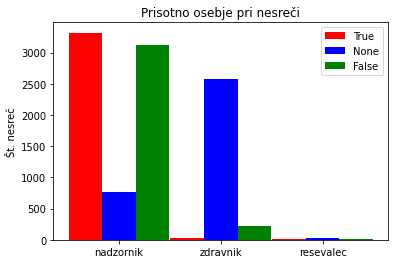

In [13]:
def present_personnel(rows):
    
    array = counter(rows, "nadzornik_prisoten")
    array = dict(sorted(array.items(), key=lambda t: (str(t[1]), str(t[0])), reverse=True))
    y1 = list(array.values())
    
    array = counter(rows, "zdravnik_prisoten")
    array = dict(sorted(array.items(), key=lambda t: (str(t[1]), str(t[0])), reverse=True))
    y2 = list(array.values())
    
    array = counter(rows, "resevalec_prisoten")
    array = dict(sorted(array.items(), key=lambda t: (str(t[1]), str(t[0])), reverse=True))
    y3 = list(array.values())

    X = np.arange(3)
    plt.bar(X + 0.00, y1, color = 'r', width = 0.33, label="True")
    plt.bar(X + 0.33, y2, color = 'b', width = 0.33, label="None")
    plt.bar(X + 0.66, y3, color = 'g', width = 0.33, label="False")

    bars = ('nadzornik', 'zdravnik', 'resevalec')
    x_pos = np.arange(len(bars)) + 0.33
    plt.xticks(x_pos, bars)
    
    plt.ylabel("Št. nesreč")
    plt.title("Prisotno osebje pri nesreči")
    plt.legend()
    plt.show()

present_personnel(data)

V tem primeru vidimo, da je nadzornik prisoten v skoraj polovici primerov, medtem ko reševalec in zdravnik nista skoraj nikoli (za zdravnika se ne ve, če je bil ali ne).

## Nesreče po starosti in stopnji poškodbe

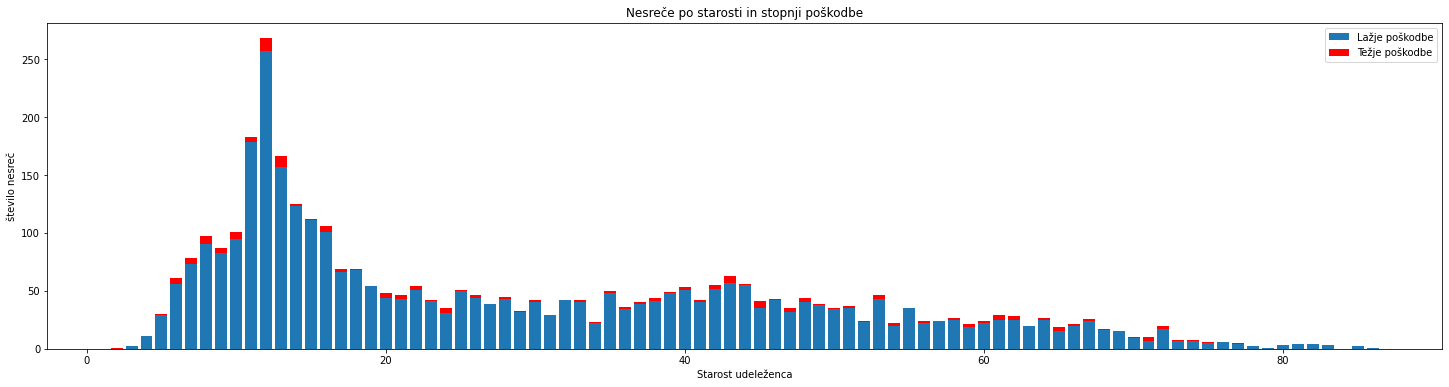

In [14]:
def accident_age(rows):
    leta_lazje = {}
    leta_tezje = {}
    
    for row in rows:
        leto_rojstva_a = row['udelezenec_a_–_leto_rojstva']
        leto_rojstva_b = row['udelezenec_b_–_leto_rojstva']
        leto_nesrece = row['datum_nesrece'][-4:]
        
        if (leto_rojstva_a != None):
            starost = int(leto_nesrece) - int(leto_rojstva_a)
            
            if(starost > 1):
                if (starost not in leta_lazje):
                    leta_lazje[starost] = 0

                if (starost not in leta_tezje):
                    leta_tezje[starost] = 0

                if (row['telesna_poskodba'] == "Lažja"):
                    leta_lazje[starost] += 1
                else:
                    leta_tezje[starost] += 1
                    
        if (leto_rojstva_b != None):
            starost = int(leto_nesrece) - int(leto_rojstva_b)
            
            if(starost > 1):
                if (starost not in leta_lazje):
                    leta_lazje[starost] = 0

                if (starost not in leta_tezje):
                    leta_tezje[starost] = 0

                if (row['telesna_poskodba'] == "Lažja"):
                    leta_lazje[starost] += 1
                else:
                    leta_tezje[starost] += 1
        
    array = dict(sorted(leta_lazje.items(), key=lambda t: int(t[0]), reverse=False))
    x = list(array.keys())
    l = list(array.values())
    
    array = dict(sorted(leta_tezje.items(), key=lambda t: int(t[0]), reverse=False))
    t = list(array.values())
    
    plt.figure(figsize=(25, 6))
    plt.title("Nesreče po starosti in stopnji poškodbe")
    plt.bar(x, l, align = 'center', label = "Lažje poškodbe")
    plt.bar(x, t, bottom = l, color = 'red', align = 'center', label = "Težje poškodbe")
    plt.xlabel("Starost udeleženca")
    plt.ylabel("število nesreč")
    plt.legend()
    plt.show()
    
accident_age(data)

Iz grafa je razvidno, da se največ nesreč zgodi mladim udeležencem saj še nimajo veliko izkušenj in so bolj nepremišljeni. Težje poškodbe se zgodijo v vsakem starostnem obdobju in zavzemajo manjši delež vseh nesreč.

## Napovedovanje trenda


In [15]:
def unique(stolpec):
    key = 0;
    xyz = [0] * 1000

    for line in data:
        if line[stolpec] not in xyz:
            xyz[key] = line[stolpec]
            key = key + 1 

    return [line for line in xyz if line != 0 and line != None]

c = unique("datum_nesrece")
c.reverse()

datumi = []
tempi = []

for line in c:
    dogodki = 0
    temper = 0
    minus = 0
    for nesreca in data:
        if line == nesreca['datum_nesrece']:
            dogodki = dogodki + 1
            
            if nesreca['temperatura'] != None and nesreca['temperatura'] != "":
                temper = temper + float(nesreca['temperatura'].replace(',', '.')) 
            else:
                minus = minus + 1
    datumi.append(dogodki)
    
    if (dogodki - minus) == 0:
        minus = minus - 1
    
    tempi.append(temper/(dogodki - minus))

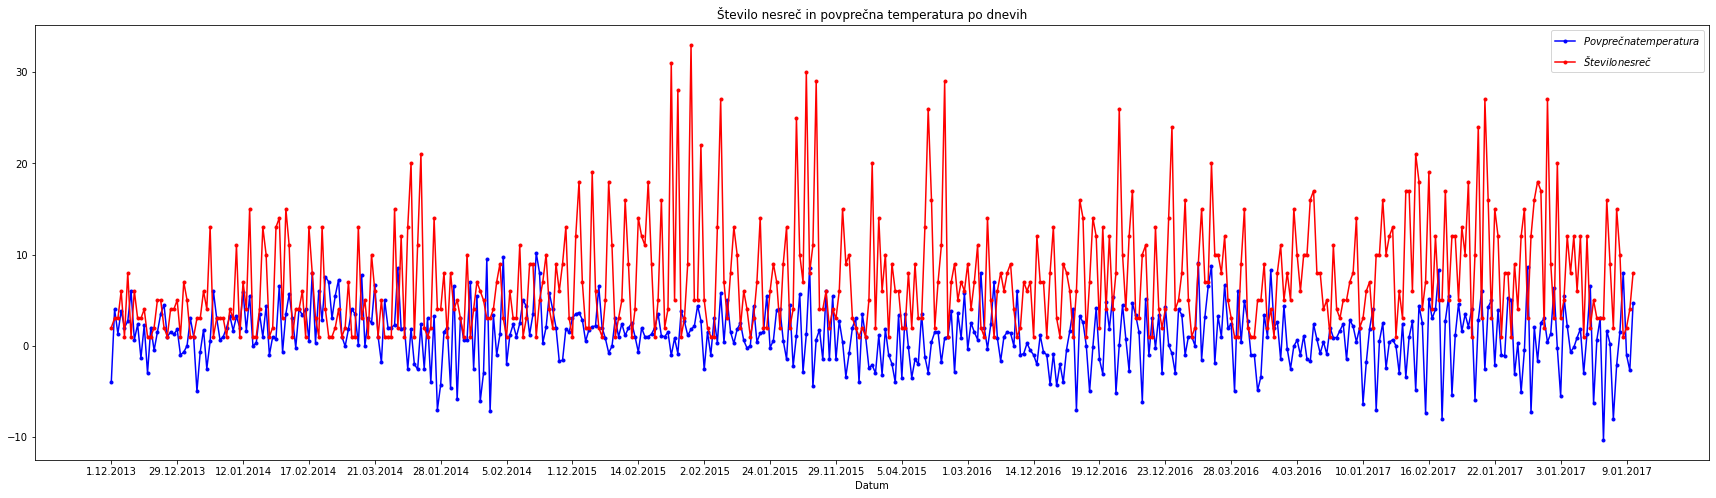

In [16]:
spodaj = [*range(0,len(c),20)]
imena = [c[ime] for ime in spodaj]

plt.figure(figsize=(30, 8))
plt.title("Število nesreč in povprečna temperatura po dnevih")
plt.plot(tempi, "b.-", label="$Povprečna temperatura$")
plt.plot(datumi, "r.-", label="$Število nesreč$")
plt.xlabel("Datum")
plt.gca().set_xticks(spodaj)
plt.gca().set_xticklabels(imena)
plt.legend()
plt.show()

Iz grafa je razvidno, da je vpliv temperature na število nesreč minimalen. Pričakovala sva, da bo temperatura imela večji vpliv na število nesreč.

{'whiskers': [<matplotlib.lines.Line2D at 0x2639b9b8>,
 'caps': [<matplotlib.lines.Line2D at 0x2639b040>,
 'boxes': [<matplotlib.lines.Line2D at 0x2639b910>],
 'medians': [<matplotlib.lines.Line2D at 0x2639b568>],
 'fliers': [<matplotlib.lines.Line2D at 0x2639ba78>],
 'means': []}

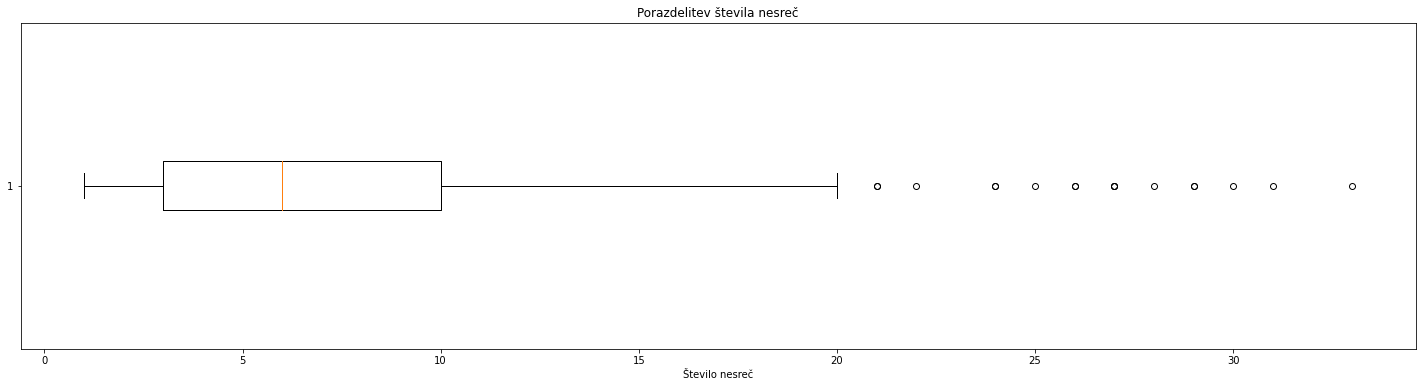

In [17]:
plt.figure(figsize=(25, 6))
plt.title("Porazdelitev števila nesreč")
plt.xlabel("Število nesreč")
plt.boxplot(datumi, vert = 0)

Škatla z brki nam prikaže, da ima mediana vrednost 6, prvi kvartil 3 in tretji kvartil 10. Izvemo tudi, da je spodnja meja za osamelce 1 in zogrnja meja 20, za katero najdemo 11 osamelcev.

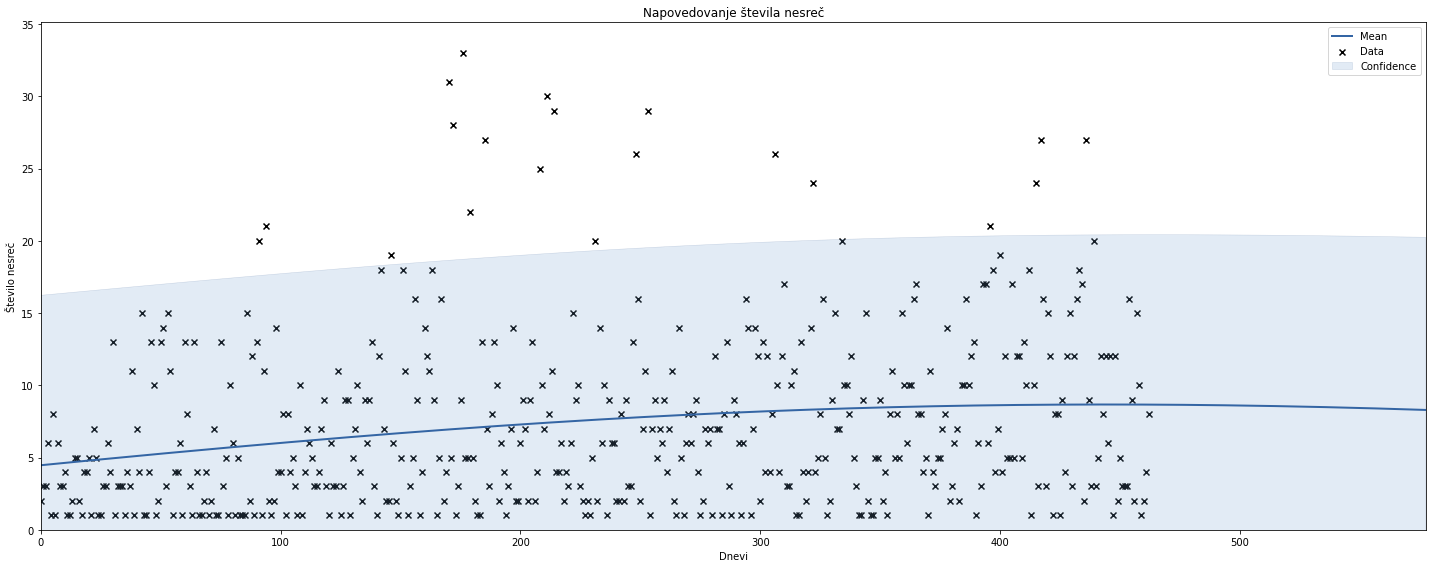

In [18]:
datumi2 = []

for i in datumi:
    datumi2.append([i])
    
c3 = [*range(0,len(c),1)]

c4 = []

for i in c3:
    c4.append([i])

kernel = GPy.kern.RBF(1, lengthscale=1)
model  = GPy.models.GPRegression(np.array(c4), np.array(datumi2), kernel, noise_var=0.1) #np.array(c2), np.array(datumi2)
model.optimize(messages=True)
model.plot(figsize=(20, 8))
plt.gca().set_xlim(0)
plt.gca().set_ylim(0)
plt.title("Napovedovanje števila nesreč")
plt.xlabel("Dnevi")
plt.ylabel("Število nesreč")
plt.show()

Model napoveduje zelo majhne spremembe v številu nesreč na dan. Število nesreč naj nebi raslo v prihodnosti. Napoveduje vrednosti za približno 100 dni naprej.

## Napovedovanje telesne poškodbe

Naredila sva model, ki pod pogojem, da se nam pripeti ensreča napove ali bo nesreča lažja ali hujša. Za gradnjo modela sva upoštevala stolpce Nadzornik prisoten, Zdravnik prisoten, Reševalec prisoten, Udeleženec A – LETO ROJSTVA, Udeleženec A – država, Udeleženec A – zvrst smučanja, Vreme, Vidljivost, Temperatura, Vrsta snega in veter. Zgradila sva modele s pomočjo Bernoullijevega Naivnega Bayesa, Gaussovega Naivnega Bayesa in Odločitvenega drevesa.

In [19]:
matrika = [] 
for i in data:
    vrsta = []
    for l in i.values():
        vrsta.append(l)
    matrika.append(vrsta)
                
matrika = np.array(matrika)
np.set_printoptions(threshold=np.inf)

drzavaA = unique('udelezenec_a_–_drzava')
zvrstSmucanjaA = unique('udelezenec_a_–_zvrst_smucanja')
vreme = unique('vreme')
vidljivost = unique('vidljivost')
vrstaSnega = unique('vrsta_snega')
veter = unique('veter')
poskodba = unique('telesna_poskodba')

for k, line in enumerate(matrika):
    
    for i, element in enumerate(drzavaA):
        if element == line[7]:
            matrika[k][7] = i;
            
    for i, element in enumerate(zvrstSmucanjaA):
        if element == line[8]:
            matrika[k][8] = i;
            
    for i, element in enumerate(vreme):
        if element == line[17]:
            matrika[k][17] = i;
            
    for i, element in enumerate(vidljivost):
        if element == line[18]:
            matrika[k][18] = i;

    if line[19] == '':
        matrika[k][19] = None
    else:
        matrika[k][19] = line[19].replace(',', '.')

    for i, element in enumerate(vrstaSnega):
        if element == line[20]:
            matrika[k][20] = i;
    
    for i, element in enumerate(veter):
        if element == line[21]:
            matrika[k][21] = i;
            
    for i, element in enumerate(poskodba):
        if element == line[22]:
            matrika[k][22] = i;
            
zadnja_matrika = []            
            
for i in matrika:
    fail = 0
    for stolpec in [3,4,5,6,7,8,17,18,19,20,21]:
        if i[stolpec] == None:
            i[stolpec] = 0

    zadnja_matrika.append(i)

zadnja_matrika = np.array(zadnja_matrika)

y = zadnja_matrika[:,22]
x = zadnja_matrika[:,[3,4,5,6,7,8,17,18,19,20,21]]
    
y = np.array(y)
x = np.array(x)

inxs = list(range(len(zadnja_matrika)))
n = len(inxs)

q = math.ceil(n * 0.75)
f = 10
podatki = [0,0,0]

for o in range(f):
    random.shuffle(inxs)

    y_train = y[inxs[:q]]
    y_test = y[inxs[q:]]

    x_train = x[inxs[:q]]
    x_test = x[inxs[q:]]
    
    model = BernoulliNB()
    y_pred = model.fit(x_train, y_train.astype('int')).predict(x_test)
    podatki[0] = podatki[0] + mean_absolute_error(y_pred, y_test)
    
    if o == 0:
        print("Prvi primer")
        print("------------------")
        print("Bernoulli")
        print("Število napak izmed %d primerov : %d" % (len(y_test), (y_test != y_pred).sum()))
        print("MAE " + str(mean_absolute_error(y_pred, y_test)))
    
    model = GaussianNB()
    y_pred = model.fit(x_train, y_train.astype('int')).predict(x_test)
    podatki[1] = podatki[1] + mean_absolute_error(y_pred, y_test)
    
    if o == 0:
        print("Gaussian")
        print("Število napak izmed %d primerov : %d" % (len(y_test), (y_test != y_pred).sum()))
        print("MAE " + str(mean_absolute_error(y_pred, y_test)))
    
    model = tree.DecisionTreeClassifier()
    y_pred = model.fit(x_train, y_train.astype('int')).predict(x_test)
    podatki[2] = podatki[2] + mean_absolute_error(y_pred, y_test)
    
    if o == 0:
        print("Drevo")
        print("Število napak izmed %d primerov : %d" % (len(y_test), (y_test != y_pred).sum()))
        print("MAE " + str(mean_absolute_error(y_pred, y_test)))

print("")
print("Povprečje MAE")
print("------------------")
print("Bernoulli                Gaussian               Drevo")
print(str(podatki[0]/f) + "     " + str(podatki[1]/f) + "   " + str(podatki[2]/f))

Prvi primer
------------------
Bernoulli
Število napak izmed 841 primerov : 38
MAE 0.04518430439952437
Gaussian
Število napak izmed 841 primerov : 48
MAE 0.057074910820451845
Drevo
Število napak izmed 841 primerov : 74
MAE 0.08799048751486326

Povprečje MAE
------------------
Bernoulli                Gaussian               Drevo
0.04673008323424494     0.06837098692033294   0.09393579072532698


Za mero napake sva si izbrala MAE (povprečno absolutno napako). Najprej sva izpisala MAE za prvi primer, potem pa še za rezultat 100-kratnega preverjanja. Iz rezultatov je razvidno, da so vsi modeli zelo zadovoljivi in da je model Bernoullijevega Naivnega Bayesa v primerjavi z drugima najbolj uspešen z MAE 0.0455.

### Gručenje

In [20]:
# vse vrste poškodb
vrste_poskodb = {}

for row in data[:500]:
    poskodba = row['telesna_poskodba']
    if poskodba not in vrste_poskodb:
        vrste_poskodb[poskodba] = len(vrste_poskodb)

In [21]:
datumi = {}

for row in data[:500]:
    datum = row['datum_nesrece']
    
    if datum not in datumi:
        datumi[datum] = len(datumi)

In [22]:
# { datum1: [1, 0, 1, ...], datum2: [0, 0, 1, ...] }
poskodbe_na_datum = {}

for row in data[:500]:
    datum = datumi[row['datum_nesrece']]
    poskodba = row['telesna_poskodba']
    
    if datum not in poskodbe_na_datum:
        poskodbe_na_datum[datum] = []
        
    poskodbe_na_datum[datum].append(vrste_poskodb[poskodba])

In [23]:
podatki = [val for _, val in poskodbe_na_datum.items()]
maximum = max([len(x) for x in podatki])

for i in range(len(podatki)):
    n = maximum - len(podatki[i])
    for j in range(n):
        podatki[i].append(-1)

In [24]:
datumi_r = {val: key for key, val in datumi.items()}

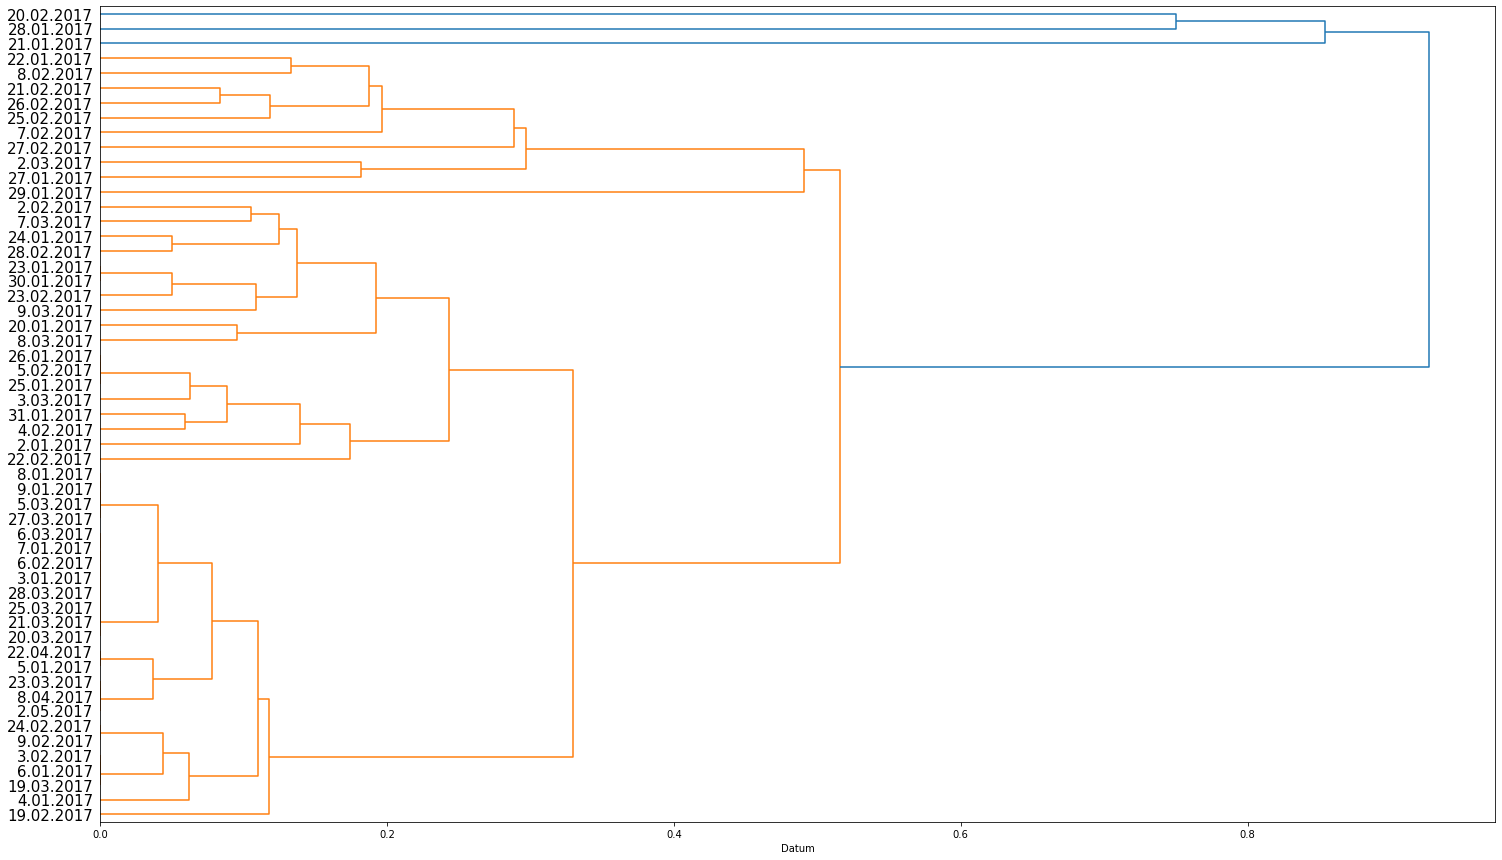

In [25]:
# dendogram
L = sch.linkage(podatki, method="average", metric="jaccard")

labels = [datumi_r[i] for i in range(len(podatki))]
plt.figure(figsize=(25, 15))
D = sch.dendrogram(L, leaf_font_size=15, labels=labels, orientation='right')
plt.xlabel("Datum")
plt.show()